In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import lightgbm as lgb

In [44]:
data=pd.read_csv('./datasets/train_set.csv')
data=data.astype(float)
data['label'].value_counts()

label
0.0    244913
1.0     15952
Name: count, dtype: int64

In [45]:
zd=data[data['label']==0].sample(n=20000)
od=data[data['label']==1]
data=pd.concat([zd,od],axis=0).reset_index(drop=True)
data['label'].value_counts()

label
0.0    20000
1.0    15952
Name: count, dtype: int64

In [46]:
Y=data['label'].__array__()
X=data.drop('label',axis=1).__array__()
train_x,test_x,train_y,test_y=train_test_split(X,Y,test_size=0.3)
train_x.shape,test_x.shape

((25166, 18), (10786, 18))

In [47]:
def plot_roc(y_test, y_score):
    fpr,tpr,threshold = skm.roc_curve(y_test, y_score)
    roc_auc = skm.auc(fpr,tpr)
    plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
    plt.plot(fpr, tpr, color='black', lw = 1)
    plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
    plt.text(0.5,0.3,'ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.show()

## LightGBM

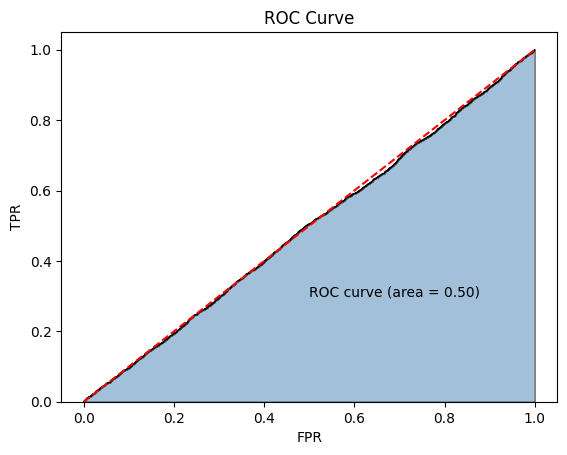

In [55]:
train_set_gbm=lgb.Dataset(train_x,label=train_y)

params={
    'learning_rate': 0.05,
    'num_leaves': 1024,  # 叶子节点数
    'metric': {'binary_logloss', 'auc'},  # 评估函数
    'objective': 'binary',  # 目标函数
    'boosting': 'rf',   #  rf:随机森林  dart:带dropout 的gbdt
    'bagging_fraction': 0.8,
    'bagging_freq': 3,
    'min_data_in_leaf': 20,
    'lambda_l2': 0.001,
    "verbosity": -1,
    'is_unbalance':True,
}
gbm = lgb.train(params, train_set_gbm, num_boost_round=500)
# 预测数据集
y_pred = gbm.predict(test_x, num_iteration=gbm.best_iteration)

plot_roc(test_y,y_pred)

### MLP方法

In [52]:
class MLP(nn.Module):
    """docstring for MLP."""
    def __init__(self,input_dim):
        super(MLP, self).__init__()
        self.mlp=nn.Sequential(
            nn.Linear(input_dim,64),nn.GELU(),
            nn.Linear(64,128),nn.GELU(),
            nn.BatchNorm1d(128),
            nn.Dropout(),
            nn.Linear(128,256),nn.GELU(),
            nn.BatchNorm1d(256),
            nn.Linear(256,128),nn.GELU(),
            nn.Linear(128,1),nn.Sigmoid()
        )
    
    def forward(self,X):
        for l in self.mlp:
            X=l(X)
        return X

class sets(Dataset):
    """docstring for dataset_."""
    def __init__(self, x,y):
        super(sets, self).__init__()
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.float32)
    
    def __getitem__(self, index):
        return {'x':self.x[index],'y':self.y[index]}
    def __len__(self,):
        return len(self.x)
    
train_set_mlp=sets(train_x,train_y)
test_set_mlp=sets(test_x,test_y)

train_dl=DataLoader(train_set_mlp,batch_size=128)
test_dl=DataLoader(test_set_mlp,batch_size=128)

model=MLP(18).cuda()

optimizer=optim.Adam(model.parameters(),lr=1e-5)
lossfuc=nn.BCELoss()
epoch=100

model.train()
for e in range(0,epoch):
    for step ,b in enumerate(train_dl):
        pred=model(b['x'].cuda())
        loss=lossfuc(pred.view(-1),b['y'].cuda())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch:',e," loss:",loss.item())
    

epoch: 0  loss: 0.6975857019424438
epoch: 1  loss: 0.686561107635498
epoch: 2  loss: 0.6982274055480957
epoch: 3  loss: 0.6971254944801331
epoch: 4  loss: 0.6849418878555298
epoch: 5  loss: 0.6911079287528992
epoch: 6  loss: 0.6981478929519653
epoch: 7  loss: 0.6962512135505676
epoch: 8  loss: 0.6960586905479431
epoch: 9  loss: 0.6866982579231262
epoch: 10  loss: 0.6888920068740845
epoch: 11  loss: 0.6912970542907715
epoch: 12  loss: 0.6977622509002686
epoch: 13  loss: 0.7000158429145813
epoch: 14  loss: 0.7008365392684937
epoch: 15  loss: 0.697997510433197
epoch: 16  loss: 0.6930797100067139
epoch: 17  loss: 0.6901823878288269
epoch: 18  loss: 0.687421441078186
epoch: 19  loss: 0.68491530418396
epoch: 20  loss: 0.6961650252342224
epoch: 21  loss: 0.6951006650924683
epoch: 22  loss: 0.6868064999580383
epoch: 23  loss: 0.6895705461502075
epoch: 24  loss: 0.6963251829147339
epoch: 25  loss: 0.6870317459106445
epoch: 26  loss: 0.6905876398086548
epoch: 27  loss: 0.7000380158424377
epoch: 

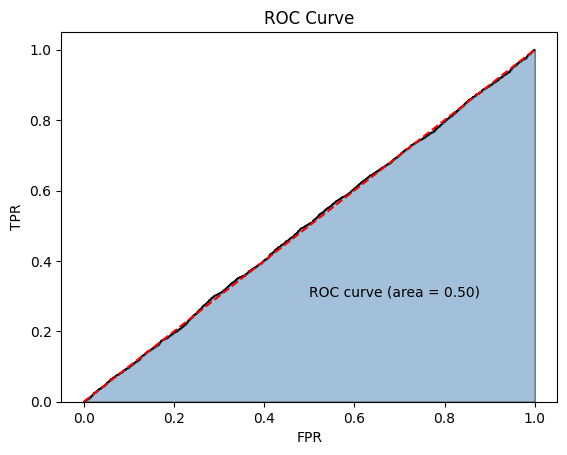

In [53]:
predlist=[]
for step,b in enumerate(test_dl):
    with torch.no_grad():
        predt=model(b['x'].cuda())
        predlist=predlist+predt.view(-1).cpu().numpy().tolist()
#predlist=np.array(predlist).reshape(-1).tolist()
plot_roc(test_y,predlist)

### XGBoost

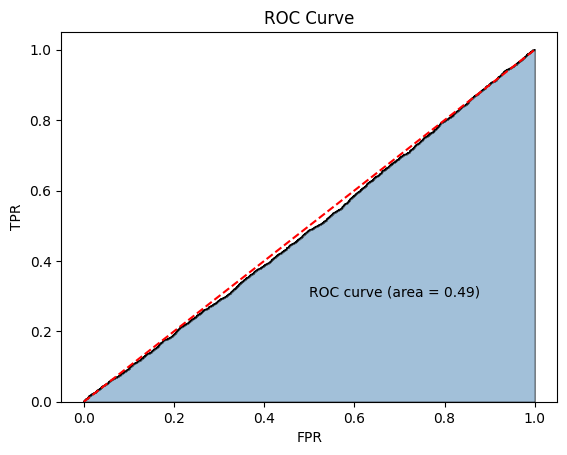

In [54]:
import xgboost as xgb
train_set_xgb=xgb.DMatrix(train_x,label=train_y)
test_set_xgb=xgb.DMatrix(test_x,label=test_y)
params={'booster':'gbtree',
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth':8,
        'lambda':10,
        'subsample':0.75,
        'colsample_bytree':0.75,
        'min_child_weight':1,
        'eta': 0.025,
        'seed':0,
        'nthread':8,
        'gamma':0,
        'learning_rate' : 0.01}
bst=xgb.train(params=params,
              dtrain=train_set_xgb,
              num_boost_round=200)
y_pred=bst.predict(test_set_xgb)
plot_roc(test_y,y_pred)

In [57]:
pred_data=pd.read_csv('./datasets/test_set.csv')
pred_raw=pd.read_csv('../../tianmao/data_format1/test_format1.csv')
pred_raw

,user_id,merchant_id,prob
0,163968,4605,NaN
1,360576,1581,NaN
2,98688,1964,NaN
3,98688,3645,NaN
4,295296,3361,NaN
...,...,...,...
261472,228479,3111,NaN
261473,97919,2341,NaN
261474,97919,3971,NaN
261475,32639,3536,NaN


In [59]:
ppp=xgb.DMatrix(pred_data.__array__())
pp=bst.predict(ppp)
pd.DataFrame(pp)

,0
0,0.438108
1,0.456428
2,0.453650
3,0.438826
4,0.426416
...,...
261472,0.445552
261473,0.439641
261474,0.409548
261475,0.416787
